# Genomic Selection Post-Training Analysis & Visualization
This notebook analyzes calibrated predicted breeding values produced by the training pipeline.

## Data Loading

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr

df = pd.read_csv('GEBVs_10foldCV.csv')
df2 = pd.read_csv('DarpaQCGenoPheno.csv')
models = ['LR','RF','GB']

ID        LR        RF        GB
0        B-1  0.432048  0.472701  0.508219
1     B-1000  0.464266  0.474574  0.416673
2     B-1002  0.470664  0.487807  0.475902
3     B-1003  0.516054  0.497794  0.500940
4     B-1005  0.542926  0.529805  0.501870
...      ...       ...       ...       ...
2352   Y_988  0.542260  0.609951  0.606434
2353   Y_991  0.614152  0.633325  0.625869
2354   Y_992  0.555010  0.597280  0.614346
2355   Y_995  0.715996  0.773480  0.733128
2356   Y_998  0.847044  0.745233  0.745356

[2357 rows x 4 columns]

In [11]:
## join to other
df2 = df2[['ID', 'Status']]
df = pd.merge(df, df2, on="ID")
df

ID        LR        RF        GB  Status
0        B-1  0.432048  0.472701  0.508219       1
1     B-1000  0.464266  0.474574  0.416673       0
2     B-1002  0.470664  0.487807  0.475902       0
3     B-1003  0.516054  0.497794  0.500940       0
4     B-1005  0.542926  0.529805  0.501870       0
...      ...       ...       ...       ...     ...
2352   Y_988  0.542260  0.609951  0.606434       1
2353   Y_991  0.614152  0.633325  0.625869       1
2354   Y_992  0.555010  0.597280  0.614346       0
2355   Y_995  0.715996  0.773480  0.733128       1
2356   Y_998  0.847044  0.745233  0.745356       1

[2357 rows x 5 columns]

## 1. Descriptive Statistics & Rank Comparison

In [12]:
# Descriptive statistics for predicted breeding values
stats = df[models].describe().T
display(stats)

# Top 100 individuals for each model and rank comparison
rankings = {}
for model in models:
    top100 = df.nlargest(100, model)[['ID', model]].copy()
    top100['Rank_in_'+model] = np.arange(1, 101)
    for other in models:
        if other != model:
            top100['Rank_in_'+other] = df[other].rank(method='min', ascending=False).loc[top100.index].astype(int)
    rankings[model] = top100

# Example output
rankings['LR'].head()

count      mean       std       min       25%       50%       75%  \
LR  2357.0  0.536786  0.118396  0.101446  0.463562  0.531924  0.610240   
RF  2357.0  0.539024  0.112968  0.178936  0.469414  0.516232  0.615064   
GB  2357.0  0.537633  0.122439  0.144825  0.459085  0.527109  0.623255   

         max  
LR  0.928281  
RF  0.902377  
GB  0.877540

ID        LR  Rank_in_LR  Rank_in_RF  Rank_in_GB
1998  Y_1263  0.928281           1           1           2
1737    P643  0.922698           2           3           1
1014  O_1207  0.909710           3          38          31
2178   Y_643  0.907196           4          63          38
1082  O_1333  0.899458           5          50          93

## 2. Breeding Value Histograms

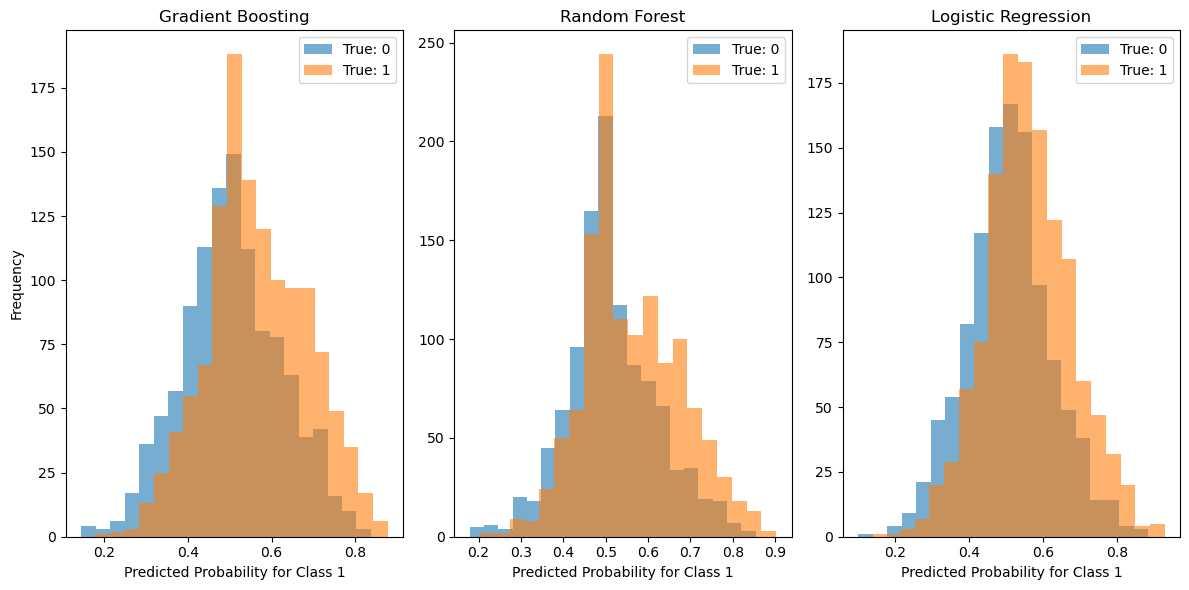

In [14]:
import matplotlib.pyplot as plt

# Extract probabilities and true labels from df
gb_class1_probs = df["GB"].values
rf_class1_probs = df["RF"].values
lr_class1_probs = df["LR"].values
y_true = df["Status"].values  # true phenotype (0/1)

plt.figure(figsize=(12, 6))

# Gradient Boosting
plt.subplot(1, 3, 1)
plt.hist(gb_class1_probs[y_true == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(gb_class1_probs[y_true == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Gradient Boosting')
plt.xlabel('Predicted Probability for Class 1')
plt.ylabel('Frequency')
plt.legend()

# Random Forest
plt.subplot(1, 3, 2)
plt.hist(rf_class1_probs[y_true == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(rf_class1_probs[y_true == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Random Forest')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

# Logistic Regression
plt.subplot(1, 3, 3)
plt.hist(lr_class1_probs[y_true == 0], bins=20, alpha=0.6, label='True: 0')
plt.hist(lr_class1_probs[y_true == 1], bins=20, alpha=0.6, label='True: 1')
plt.title('Logistic Regression')
plt.xlabel('Predicted Probability for Class 1')
plt.legend()

plt.tight_layout()
plt.show()


## 3. Correlation & Performance Plot

LR: Pearson correlation = 0.232 (p=4.751e-30)
RF: Pearson correlation = 0.207 (p=2.688e-24)
GB: Pearson correlation = 0.248 (p=2.370e-34)


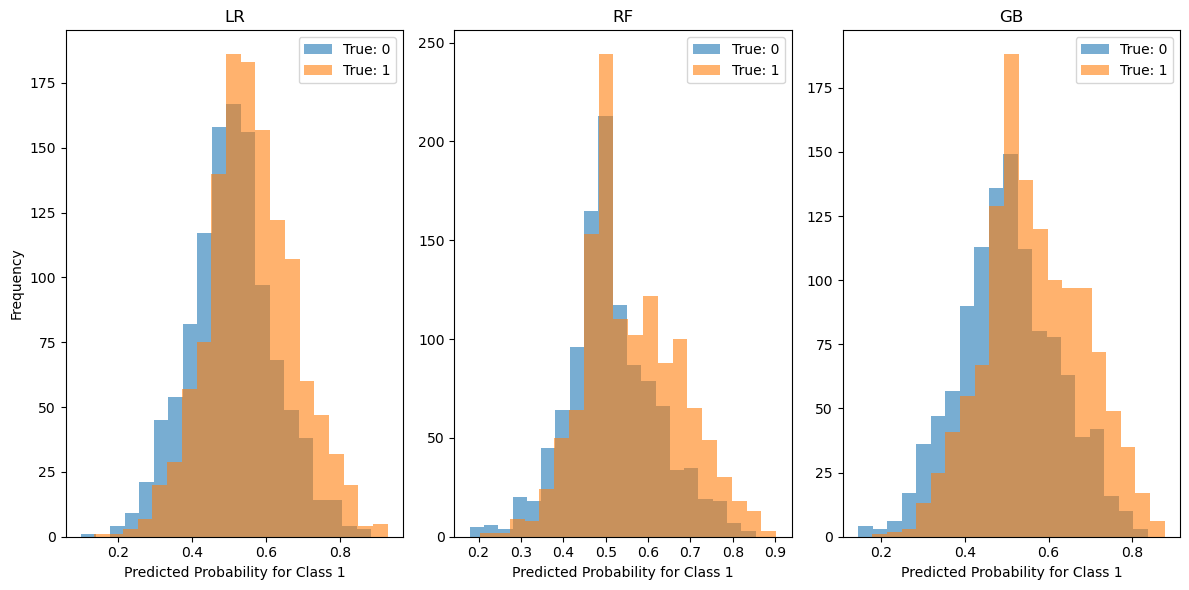

In [17]:
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

y_true = df["Status"].values
model_names = ["LR", "RF", "GB"]

for model in model_names:
    corr, pval = pearsonr(df[model].values, y_true)
    print(f"{model}: Pearson correlation = {corr:.3f} (p={pval:.3e})")

plt.figure(figsize=(12, 6))

for i, model in enumerate(model_names, 1):
    probs = df[model].values
    plt.subplot(1, 3, i)
    plt.hist(probs[y_true == 0], bins=20, alpha=0.6, label="True: 0")
    plt.hist(probs[y_true == 1], bins=20, alpha=0.6, label="True: 1")
    plt.title(f"{model}")
    plt.xlabel("Predicted Probability for Class 1")
    plt.ylabel("Frequency" if i == 1 else "")
    plt.legend()

plt.tight_layout()
plt.show()


In [15]:
# # Compute correlations per fold
# correlations = []
# for model in models:
#     fold_corrs = []
#     for fold in df['fold'].unique():
#         subset = df[df['fold'] == fold]
#         corr, _ = pearsonr(subset['true_label'], subset[model])
#         fold_corrs.append(corr)
#     correlations.append({
#         'Model': model,
#         'MeanCorr': np.mean(fold_corrs),
#         'SE': np.std(fold_corrs, ddof=1) / np.sqrt(len(fold_corrs))
#     })

# corr_df = pd.DataFrame(correlations)
# display(corr_df)

# # Bar chart with error bars
# plt.figure(figsize=(8, 6))
# plt.bar(corr_df['Model'], corr_df['MeanCorr'], yerr=corr_df['SE'], capsize=5, color='lightgreen')
# plt.ylabel('Pearson Correlation (True vs Predicted)')
# plt.title('Average Correlation with Survival (10-fold CV)')
# plt.show()

KeyError: 'fold'

## 4. Model Correlation Plot

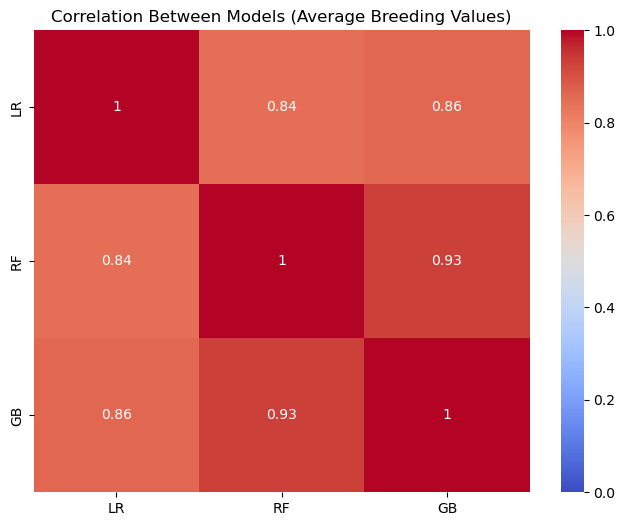

In [16]:
# Average breeding value per individual across folds
avg_preds = df.groupby('ID')[models].mean()

# Pairwise Pearson correlations
corr_matrix = avg_preds.corr(method='pearson')

plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Correlation Between Models (Average Breeding Values)')
plt.show()